# AIPI 590 - XAI | Adversarial Patches
### Write code, that when embedded in a sticker, displays the class "chambered nautilus" for any object
### Mariam Khan

[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Mkhan13/XAI/blob/main/adversarial_patch.ipynb)

In [200]:
!pip install -q torch torchvision pillow matplotlib requests

In [201]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet34, ResNet34_Weights
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import requests
from pathlib import Path

In [202]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # Use GPU if available

In [203]:
weights = ResNet34_Weights.IMAGENET1K_V1 # Load Imagenet weights
model = resnet34(weights=weights).to(device).eval()
preprocess = weights.transforms() # PReprocess

In [204]:
classes_url = 'https://raw.githubusercontent.com/AIPI-590-XAI/Duke-AI-XAI/main/adversarial-ai-example-notebooks/imagenet_classes.txt' # Load Imagenet classes
response = requests.get(classes_url) # Download file
text_data = response.text
clean_text = text_data.strip() # Clean data
imagenet_classes = clean_text.split("\n") # Split text into list


name = 'chambered nautilus'
target_index = None
for i, class_name in enumerate(imagenet_classes): # Find index of target class
    if name in class_name:
        target_index = i
        break
print(target_index, name)

117 chambered nautilus


In [205]:
test_image = 'https://images.unsplash.com/photo-1521572163474-6864f9cf17ab?w=800'

# Download and open the image first
img = Image.open(requests.get(test_image, stream=True).raw).convert("RGB")
image_array = np.array(img)  # Convert image to numpy array

image_tensor = torch.from_numpy(image_array).float()  # Convert numpy to float tensor
image_tensor = image_tensor.permute(2, 0, 1)  # Rearrange from (H,W,C) to (C,H,W)
image_tensor = image_tensor.to(device) / 255.0  # Move to device

In [206]:
PATCH = 200
y_grid, x_grid = torch.meshgrid(torch.arange(PATCH), torch.arange(PATCH), indexing='ij') # Create coordinate grids for x and y
center_x = PATCH / 2
center_y = PATCH / 2
dist_squared = (x_grid - center_x)**2 + (y_grid - center_y)**2 # Find image center

mask_bool = dist_squared <= (PATCH/2)**2
mask = mask_bool.float().to(device)

In [207]:
patch_param = torch.randn(1, 3, PATCH, PATCH, device=device, requires_grad=True) # Random values for patch
optimizer = optim.Adam([patch_param], lr=0.1)

In [208]:
for step in range(500):
    patch = torch.sigmoid(patch_param)

    img_copy = image_tensor.clone() # Make a copy of the original image tensor
    h, w = image_tensor.shape[1], image_tensor.shape[2]
    y, x = (h - PATCH) // 2, (w - PATCH) // 2 # Put patch in center of image

    mask_3d = mask.unsqueeze(0)  # shape (1,H,W)
    patch_flat = patch.squeeze(0) # shape (3,H,W)
    img_copy[:, y:y+PATCH, x:x+PATCH] = patch_flat * mask_3d + img_copy[:, y:y+PATCH, x:x+PATCH] * (1 - mask_3d)

    inp = preprocess(img_copy).unsqueeze(0)
    out = model(inp)

    log_probs = torch.nn.functional.log_softmax(out, dim=1) # log softmax over classes
    target_log_prob = log_probs[0, target_index] # pick target class
    loss = -target_log_prob # negative log probability of target class

    optimizer.zero_grad() # Optimize
    loss.backward() # Back propogation
    optimizer.step()

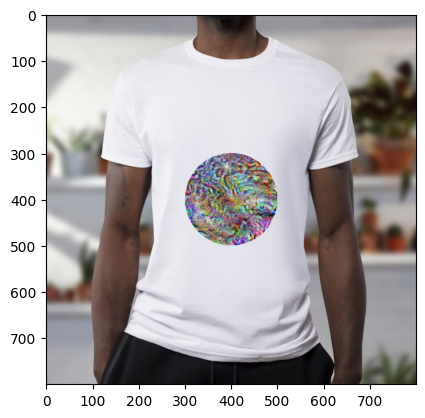

In [209]:
final_patch = torch.sigmoid(patch_param).detach().cpu() # Apply sigmoid to final patch
result = img_copy.detach().cpu().permute(1, 2, 0).numpy() * 255 # Apply patch
result = result.astype(np.uint8)

plt.imshow(result)
plt.show()

In [210]:
pred = torch.softmax(out, 1)[0]
print("Top 5 Predictions:")
top5 = pred.topk(5)
for i, p in zip(top5.indices, top5.values): # Get top 5 predictions
    print(f"{imagenet_classes[i]}: {p.item():.3f}")

Top 5 Predictions:
chambered nautilus: 1.000
snail: 0.000
jersey: 0.000
conch: 0.000
Dungeness crab: 0.000


#### **The patch successfuly predicted the white tshirt as a chambered nautilus!**

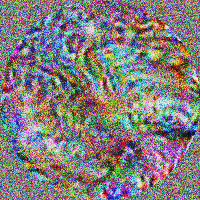

In [211]:
Path("outputs").mkdir(exist_ok=True)
sticker_array = (final_patch.squeeze().permute(1, 2, 0).numpy() * 255).astype(np.uint8)
sticker_img = Image.fromarray(sticker_array)

display(sticker_img)

Sources used for code reference:   
https://davidstutz.de/adversarial-patches-and-frames-in-pytorch/  
https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial10/Adversarial_Attacks.html